In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import MWETokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import plotly.graph_objs as go  # Import 'go' from Plotly
import chart_studio.plotly as py  # Import 'py' module from Plotly
from sklearn.decomposition import LatentDirichletAllocation
import statsmodels.api as sm

In [15]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ryounes/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
def read_chunks(file, cols, chunk_size=500000):
    df = pd.read_json(
        f'/Users/ryounes/Documents/Feup/RecSNA_Project/yelp_academic_dataset_{file}.json', chunksize = chunk_size, lines=True)
    
    chunk_list = [chunk[cols] for chunk in df ]

    return pd.concat(chunk_list, ignore_index = True, join = 'outer', axis = 0)

In [3]:
business_json_path = '/Users/ryounes/Documents/Feup/RecSNA_Project/yelp_academic_dataset_business.json'
df_b = pd.read_json(business_json_path, lines=True)

In [4]:
df_u = read_chunks('user', ['user_id','name','review_count', 'friends'])

In [48]:
df_r = read_chunks('review', ['review_id','user_id', 'business_id','stars','text','date'])

In [49]:
df_Franklin_b = df_b[df_b['city']== 'Franklin']
business_ids_Franklin = df_Franklin_b['business_id'].unique()
df_r_Franklin = df_r[df_r['business_id'].isin(business_ids_Franklin)]

In [50]:
df_r_Franklin

,review_id,user_id,business_id,stars,text,date
406,89SF8MFoiY4mIhOgzAMVhA,S8rqFLdHCFAeibs52a4QpQ,kKk_2OAnCRbxX5rLqQYBHg,5,Thoroughly enjoyed our private tour today with...,2015-03-05 04:53:21
425,HyD8P-CcFU3FR75T0dJAhA,YsaJXW7VWV2bhoN5tokKrg,HCqmx4ENAZ76SAjoalj-MQ,4,"The restaurant was very nicely decorated , and...",2017-03-03 21:37:52
693,3B41BdxNIENFP1EsCCybnw,B0fzg0eUWplNBzfSJsCFDg,VUOD8yD1jwq_pqRP8EETBQ,3,Second time's the charm. Stopped by once to ha...,2017-03-15 20:45:43
802,h0N47vwJhQMBH9mscX9zhw,11jQWQYTJkzIE6o3s5ID4Q,hn3Rg2JrhQoDJBEhrpuwWg,1,Three chances and they are out! We tried to li...,2013-12-06 23:35:16
804,cgppGTg8LpqZObn_k69w2Q,TSxzAqKzU2OvjWSLoSU8dA,skN2XhKXlcjf53uIwzAedw,5,Due to it's location in a strip mall near Cool...,2016-03-07 01:47:53
...,...,...,...,...,...,...
6989373,Rjv4qf02STIbSUu5mq4W4w,U0kiORl1Gpc8K9jOWWgHzg,yi5VHfhTIPopCob2toQH8A,1,We walk here from main st Franklin walked in a...,2021-07-15 21:03:25
6989504,B50r7a0YV-WnBgf3bW-Dyw,H9AGj0t3ghPaHug0Ri3kOQ,y8AENR609baGvVe-d_F-dg,1,I went in to purchase a comfortable therapeuti...,2016-11-20 15:26:57
6989863,lbhfWHGz3C6dyLp_aiKadg,EUITvLX8HgKpJPs8ngXRPw,7rxLUgFNwAWd69Y4iZnUCA,5,I've at taco's all over Nashville. You name it...,2021-12-01 00:06:41
6990131,sXMx4wAegK38PRbzyWe5Bg,4Ry0q14UDewv2LMa2wibCQ,IoRTm7IAJqBbHpiisUBnLg,4,We came here for a quick bite while on vacatio...,2021-11-02 15:52:13


In [51]:
df_r_Franklin.reset_index(drop=True, inplace = True)

In [54]:
corpus = []
ps = PorterStemmer()
sw = set(stopwords.words('english'))
for i in range(0, df_r_Franklin['text'].size):
    # get review and remove non alpha chars
    review = re.sub('[^a-zA-Z]', ' ', df_r_Franklin['text'][i])
    # to lower-case
    review = review.lower()
    # split into tokens, apply stemming and remove stop words
    review = ' '.join([ps.stem(w) for w in review.split() if w not in sw])
    corpus.append(review)

#print(corpus)

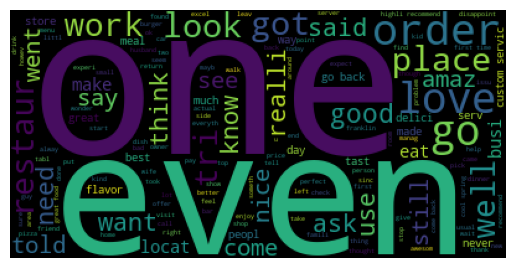

In [55]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud().generate(" ".join(corpus))

plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

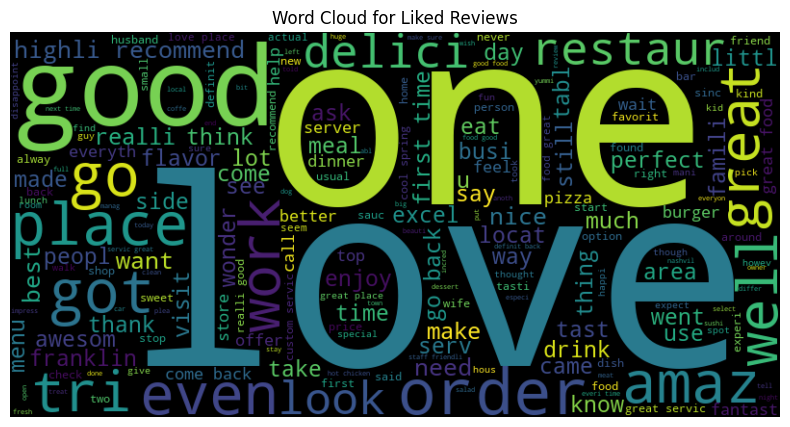

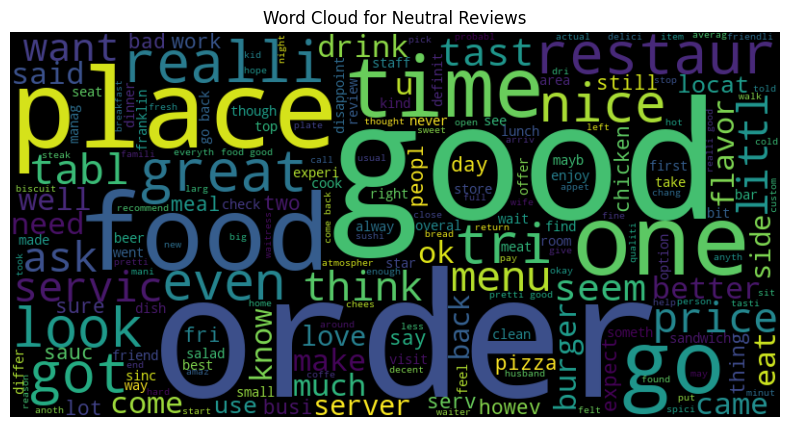

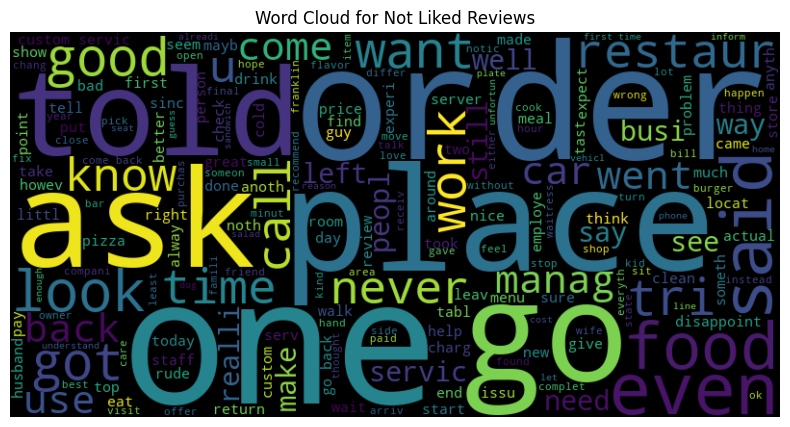

In [57]:
# your code here
liked_reviews = []
not_liked_reviews = []
neutral_reviews = []
ps = PorterStemmer()
sw = set(stopwords.words('english'))
for i in range(0, df_r_Franklin['text'].size):
    # get review and remove non alpha chars
    review = re.sub('[^a-zA-Z]', ' ', df_r_Franklin['text'][i])
    # to lower-case
    review = review.lower()
    # split into tokens, apply stemming and remove stop words
    review = ' '.join([ps.stem(w) for w in review.split() if w not in sw])
    if df_r_Franklin["stars"][i] > 3:
        liked_reviews.append(review)
    elif df_r_Franklin["stars"][i] == 3 :
        neutral_reviews.append(review)
    else :
        not_liked_reviews.append(review)

# Create word clouds for liked and not liked reviews
def create_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400).generate(" ".join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(title)
    plt.axis("off")
    plt.show()

create_wordcloud(liked_reviews, "Word Cloud for Liked Reviews")
create_wordcloud(neutral_reviews, "Word Cloud for Neutral Reviews")
create_wordcloud(not_liked_reviews, "Word Cloud for Not Liked Reviews")

# Topic Modelling 

In [472]:
# Define helper function to print top words
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

In [474]:
#Add Lemmatizer to class 
lemm = WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

In [68]:


nltk.download('wordnet')
# Storing the entire training text in a list
text = list(df_r_Franklin_ten.text.values)
# Calling our overwritten Count vectorizer
tf_vectorizer = LemmaCountVectorizer(max_df=0.95, 
                                     min_df=2,
                                     stop_words='english',
                                     decode_error='ignore')
tf = tf_vectorizer.fit_transform(text)

[nltk_data] Downloading package wordnet to /Users/ryounes/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [149]:
lda = LatentDirichletAllocation(n_components=11, max_iter=5,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0)

In [150]:
lda.fit(tf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=11, random_state=0)

In [151]:
n_top_words = 10
print("\nTopics in LDA model: ")
tf_feature_names = tf_vectorizer.get_feature_names_out()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model: 

Topic #0:store like price just shop don cool thing franklin lot

Topic #1:chicken good food place ordered cheese sauce delicious salad like

Topic #2:room coffee clean hotel stay area floor nice like parking

Topic #3:time just order food minute service got like didn don

Topic #4:car vehicle service dealership wash repair oil sale mile new

Topic #5:taco mexican salsa bowl authentic margarita burrito queso tortilla juice

Topic #6:told called day dog customer said phone service week company

Topic #7:great time place staff recommend service ve friendly experience best

Topic #8:tour house lobster history notch haircut theater franklin photo guide

Topic #9:massage dr office care mask doctor pain patient treatment health

Topic #10:food great good place service pizza bar restaurant burger menu


In [94]:
# Obtain topic distributions for documents
document_topic_distributions = lda.transform(tf)

# Each row in document_topic_distributions represents a document,
# and the columns represent the probabilities of each topic for that document.
print("Topic Distributions for Documents:")
print(document_topic_distributions)
print(document_topic_distributions.shape)

Topic Distributions for Documents:
[[0.00505053 0.00505163 0.00505058 ... 0.94948594 0.00505053 0.00505055]
 [0.00293257 0.91290752 0.00293315 ... 0.00293257 0.00293255 0.06069811]
 [0.05313629 0.00221739 0.0022174  ... 0.00221733 0.00221731 0.00221741]
 ...
 [0.00324702 0.5510901  0.00324699 ... 0.00324676 0.00324677 0.27013436]
 [0.00211422 0.24208643 0.00211425 ... 0.00211431 0.00211423 0.68623452]
 [0.2170347  0.07619881 0.1045125  ... 0.00096719 0.00096715 0.37428859]]
(56783, 11)


In [369]:
# setting the index to datetime
df_r_Franklin['date'] = pd.to_datetime(df_r_Franklin['date'])
df_r_Franklin['year'] = df_r_Franklin['date'].dt.year
df_r_Franklin['year-month'] = df_r_Franklin['date'].dt.to_period('M')
df_r_Franklin['Date (by month)'] = df_r_Franklin['year-month'].dt.to_timestamp()
df_r_Franklin = df_r_Franklin.set_index('Date (by month)')


In [374]:
#Filtering from 2010 
starting_date = pd.to_datetime('2010-01-01')
df_r_Franklin_ten = df_r_Franklin[df_r_Franklin.index >= starting_date]

In [127]:
#Getting the distribution of topics 

topic_distributions_df = pd.DataFrame(document_topic_distributions)
n_top_words = 40

tf_feature_names = tf_vectorizer.get_feature_names_out()
topics = []
for index, topic in enumerate(lda.components_):
        
        topics.append([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])

topic_distributions_df.columns = [" ".join(topic[:6]) for topic in topics]

topic_distributions_df = topic_distributions_df.set_index(df_r_Franklin.index)
df_r_Franklin = pd.concat([df_r_Franklin_ten, topic_distributions_df], axis=1)
df_r_Franklin

,review_id,user_id,business_id,stars,text,date,year,year-month,topic_distributions,store like price just shop don,chicken good food place ordered cheese,room coffee clean hotel stay area,time just order food minute service,car vehicle service dealership wash repair,taco mexican salsa bowl authentic margarita,told called day dog customer said,great time place staff recommend service,tour house lobster history notch haircut,massage dr office care mask doctor,food great good place service pizza
Date (by month),,,,,,,,,,,,,,,,,,,,
2015-03-01,89SF8MFoiY4mIhOgzAMVhA,S8rqFLdHCFAeibs52a4QpQ,kKk_2OAnCRbxX5rLqQYBHg,5,Thoroughly enjoyed our private tour today with...,2015-03-05 04:53:21,2015.0,2015-03,NaN,0.005051,0.005052,0.005051,0.005053,0.005051,0.005051,0.005053,0.005054,0.949486,0.005051,0.005051
2017-03-01,HyD8P-CcFU3FR75T0dJAhA,YsaJXW7VWV2bhoN5tokKrg,HCqmx4ENAZ76SAjoalj-MQ,4,"The restaurant was very nicely decorated , and...",2017-03-03 21:37:52,2017.0,2017-03,NaN,0.002933,0.912908,0.002933,0.002933,0.002933,0.002933,0.002933,0.002933,0.002933,0.002933,0.060698
2017-03-01,3B41BdxNIENFP1EsCCybnw,B0fzg0eUWplNBzfSJsCFDg,VUOD8yD1jwq_pqRP8EETBQ,3,Second time's the charm. Stopped by once to ha...,2017-03-15 20:45:43,2017.0,2017-03,NaN,0.053136,0.002217,0.002217,0.285639,0.061244,0.002217,0.002217,0.584459,0.002217,0.002217,0.002217
2013-12-01,h0N47vwJhQMBH9mscX9zhw,11jQWQYTJkzIE6o3s5ID4Q,hn3Rg2JrhQoDJBEhrpuwWg,1,Three chances and they are out! We tried to li...,2013-12-06 23:35:16,2013.0,2013-12,NaN,0.048282,0.256668,0.152940,0.151911,0.001515,0.001515,0.113016,0.001515,0.001515,0.001515,0.269608
2016-03-01,cgppGTg8LpqZObn_k69w2Q,TSxzAqKzU2OvjWSLoSU8dA,skN2XhKXlcjf53uIwzAedw,5,Due to it's location in a strip mall near Cool...,2016-03-07 01:47:53,2016.0,2016-03,NaN,0.001595,0.236876,0.001595,0.001595,0.001595,0.001595,0.001595,0.001595,0.001595,0.001595,0.748769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-01,Rjv4qf02STIbSUu5mq4W4w,U0kiORl1Gpc8K9jOWWgHzg,yi5VHfhTIPopCob2toQH8A,1,We walk here from main st Franklin walked in a...,2021-07-15 21:03:25,2021.0,2021-07,NaN,0.005348,0.005348,0.005348,0.669728,0.005348,0.005348,0.109138,0.005348,0.178351,0.005348,0.005348
2016-11-01,B50r7a0YV-WnBgf3bW-Dyw,H9AGj0t3ghPaHug0Ri3kOQ,y8AENR609baGvVe-d_F-dg,1,I went in to purchase a comfortable therapeuti...,2016-11-20 15:26:57,2016.0,2016-11,NaN,0.319975,0.000745,0.117131,0.128166,0.000745,0.000745,0.322541,0.065134,0.020636,0.023436,0.000745
2021-12-01,lbhfWHGz3C6dyLp_aiKadg,EUITvLX8HgKpJPs8ngXRPw,7rxLUgFNwAWd69Y4iZnUCA,5,I've at taco's all over Nashville. You name it...,2021-12-01 00:06:41,2021.0,2021-12,NaN,0.003247,0.551090,0.003247,0.003247,0.003247,0.152800,0.003247,0.003247,0.003247,0.003247,0.270134


<Axes: title={'center': 'Reviews By Topic: \nCar Vehicle Service Dealership Wash Repair'}, xlabel='Date (by month)'>

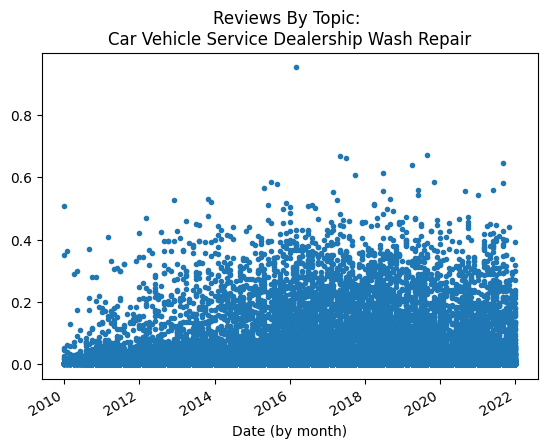

In [377]:
topic_number = 4

topic_label = " ".join(topics[topic_number][:6])

df_r_Franklin_ten[topic_label].plot(style='.', title=f'Reviews By Topic: \n{topic_label.title()}')

<Axes: title={'center': 'Reviews By Topic: \nRoom Coffee Clean Hotel Stay Area'}, xlabel='Date (by month)'>

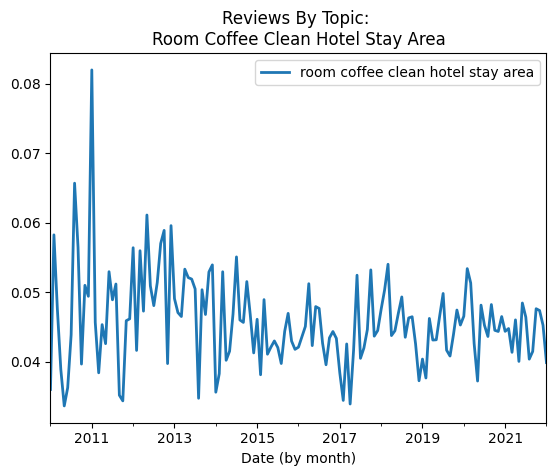

In [454]:
topic_number = 2

topic_label = " ".join(topics[topic_number][:6])

df_r_Franklin_ten.groupby(df_r_Franklin_ten.index)[[topic_label]].mean().plot(title=f'Reviews By Topic: \n{topic_label.title()}', linewidth=2)

<Axes: title={'center': 'Reviews By Topic: \nMassage Dr Office Care Mask Doctor'}, xlabel='Date (by month)'>

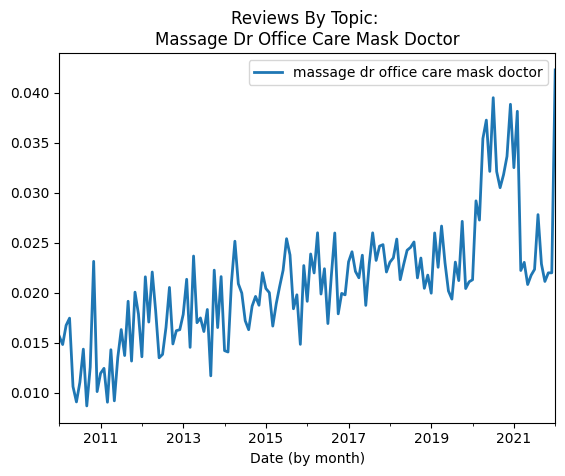

In [379]:
topic_number = 9

topic_label = " ".join(topics[topic_number][:6])

df_r_Franklin_ten.groupby(df_r_Franklin_ten.index)[[topic_label]].mean().plot(title=f'Reviews By Topic: \n{topic_label.title()}', linewidth=2)

<Axes: title={'center': 'Reviews By Topic: \nChicken Good Food Place Ordered Cheese'}, xlabel='Date (by month)'>

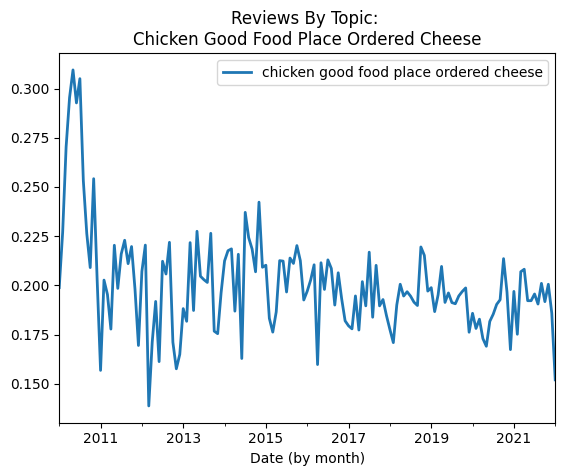

In [380]:
topic_number = 1

topic_label = " ".join(topics[topic_number][:6])

df_r_Franklin_ten.groupby(df_r_Franklin_ten.index)[[topic_label]].mean().plot(title=f'Reviews By Topic: \n{topic_label.title()}', linewidth=2)

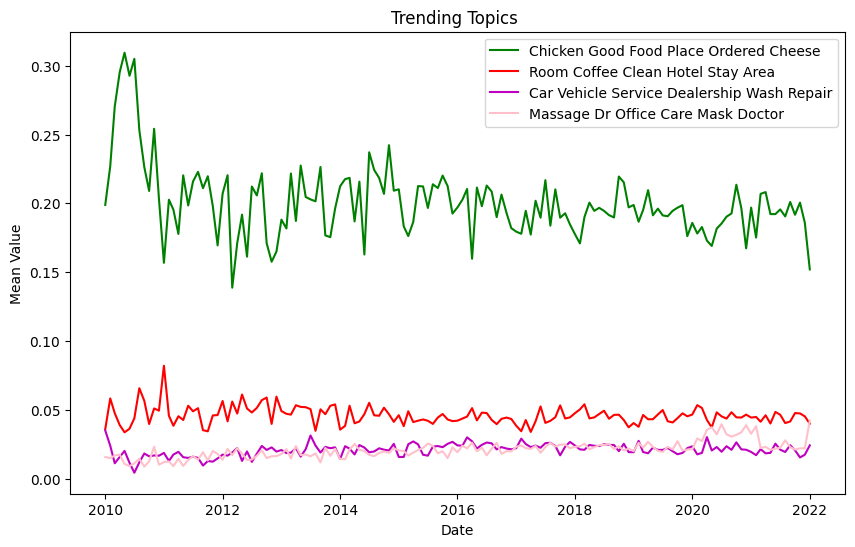

In [470]:
import matplotlib.pyplot as plt

# Assuming you have already defined 'df_r_Franklin' and 'topics'

# Create an empty DataFrame to store the mean values for each topic
topic_means = pd.DataFrame(index=df_r_Franklin_ten.index)
all_plots = []
titles = []
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple', 'orange', 'pink', 'brown']
list = [1,2,4,9]
# Iterate through topic numbers from 0 to 10
fig, ax = plt.subplots(figsize=(10, 6))
for topic_number in list:
    topic_label = " ".join(topics[topic_number][:6])
    ax.plot(df_r_Franklin_ten.groupby(df_r_Franklin_ten.index)[[topic_label]].mean(), label=f'{topic_label.title()}', color=colors[topic_number])
    




# Add labels, legend, and title
ax.set_xlabel('Date')
ax.set_ylabel('Mean Value')
ax.set_title('Trending Topics ')
ax.legend()

# Display the figure
plt.show()



In [465]:
topic_number = 9
topic_label = " ".join(topics[topic_number][:6])
monthly_mean = df_r_Franklin_ten[topic_label].resample('M').mean().ffill()
decomposition_add = sm.tsa.seasonal_decompose(monthly_mean, model='additive', period = 30)


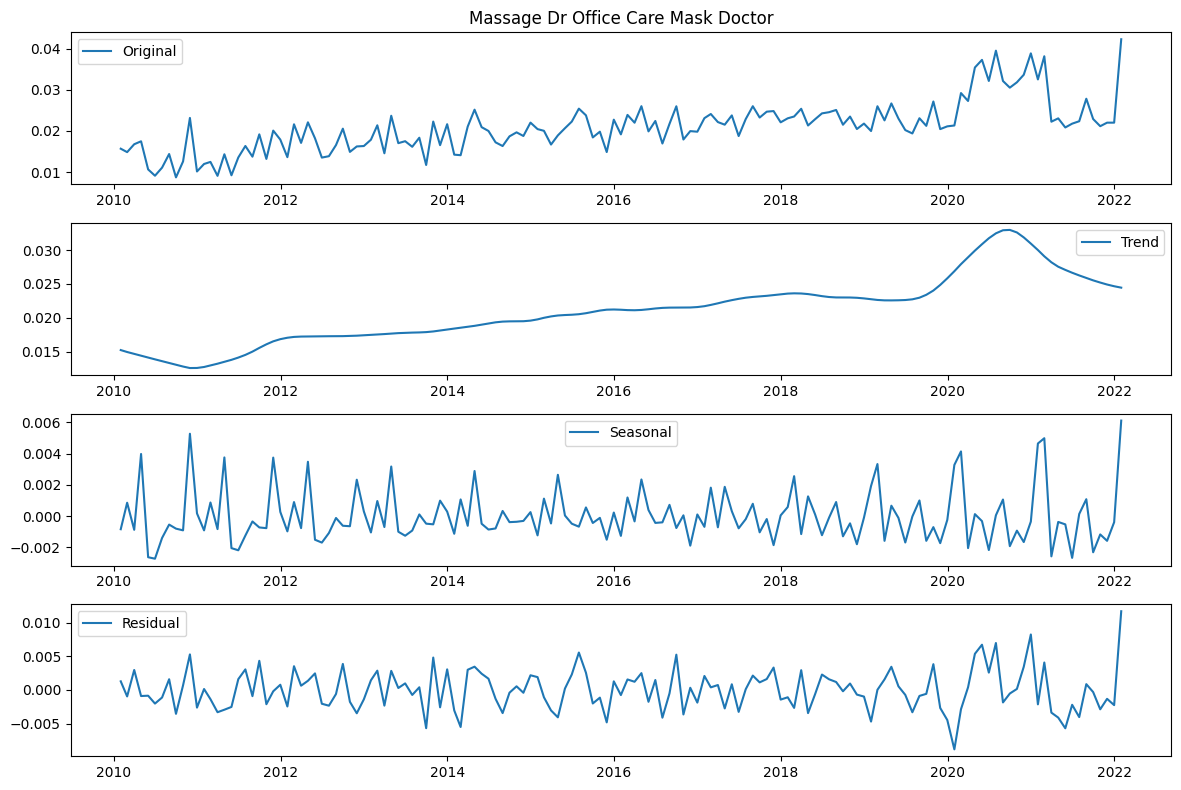

In [466]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# Load your time series data into a Pandas DataFrame
# Assuming you have a DataFrame named 'df' with a datetime index
# 'df' should have a column with the time series values, e.g., 'value'

# Perform STL decomposition
stl = STL(monthly_mean, seasonal=13)  # 'seasonal' is the window size for seasonal component estimation
result = stl.fit()

# Extract the components
seasonal = result.seasonal
trend = result.trend
residual = result.resid

# Plot the components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(monthly_mean, label='Original')
plt.legend(loc='best')
plt.title(f'{topic_label.title()}')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


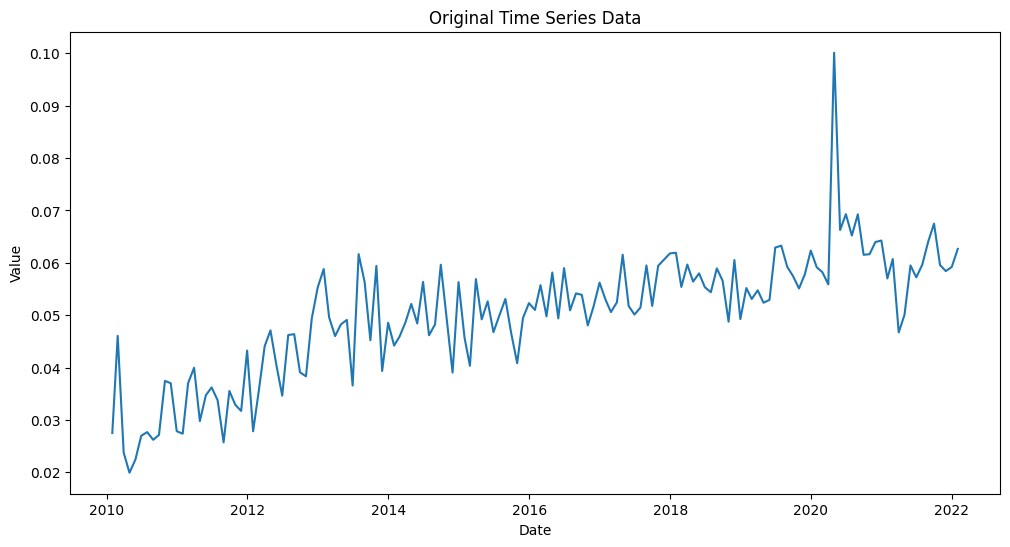

In [384]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

# Load your time series data into a Pandas DataFrame
# Assuming you have a DataFrame named 'df' with a datetime index
# 'df' should have a column with the time series values, e.g., 'value'

# Plot the original time series data
plt.figure(figsize=(12, 6))
plt.plot(monthly_mean)
plt.title('Original Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()





ADF Statistic: -2.191033982031176
p-value: 0.20951568312139446
Critical Values:
   1%: -3.4776006742422374
   5%: -2.882265832283648
   10%: -2.5778219289774156


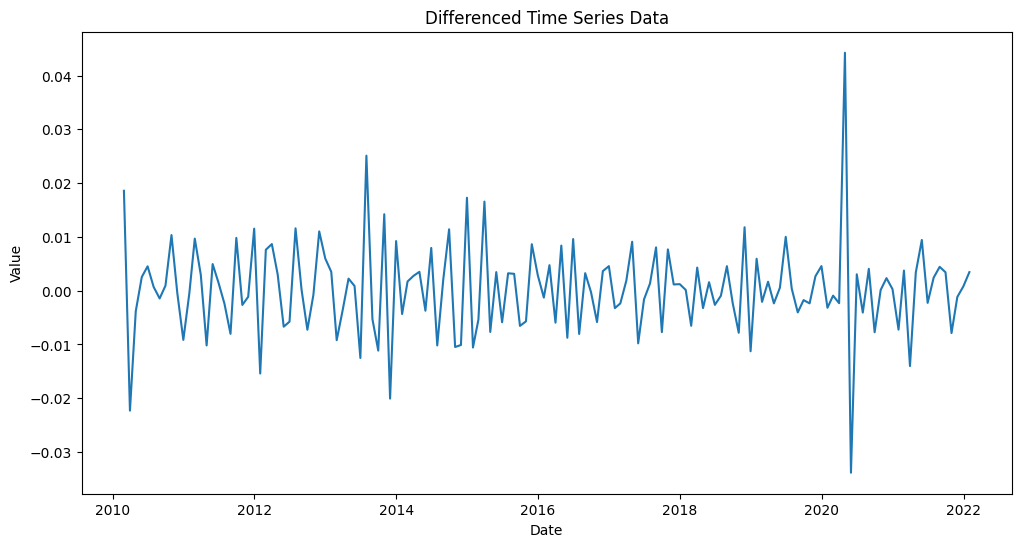

ADF Statistic (Differenced): -7.290388630176261
p-value (Differenced): 1.4222983256864424e-10
Critical Values (Differenced):
   1%: -3.479007355368944
   5%: -2.8828782366015093
   10%: -2.5781488587564603


In [385]:
# Check for stationarity (using Augmented Dickey-Fuller Test)

# Define column names
columns = ['value_diff']

# Create an empty DataFrame with the specified columns
df = pd.DataFrame(columns=columns)



result = adfuller(monthly_mean)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

# If the data is non-stationary, apply differencing to make it stationary
if result[1] > 0.05:
    df['value_diff'] = monthly_mean.diff().dropna()

    # Plot the differenced data
    plt.figure(figsize=(12, 6))
    plt.plot(df['value_diff'])
    plt.title('Differenced Time Series Data')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.show()

    # Check stationarity again
    result_diff = adfuller(df['value_diff'].dropna())
    print('ADF Statistic (Differenced):', result_diff[0])
    print('p-value (Differenced):', result_diff[1])
    print('Critical Values (Differenced):')
    for key, value in result_diff[4].items():
        print(f'   {key}: {value}')

In [452]:
topic_number = 9
topic_label = " ".join(topics[topic_number][:6])
monthly_mean_pets = df_r_Franklin_ten[topic_label].resample('M').mean().ffill()
decomposition_add = sm.tsa.seasonal_decompose(monthly_mean, model='additive', period = 30)

In [401]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [403]:
check_stationarity(Stationnary_Data['value_diff'])

ADF Statistic: -7.290389
p-value: 0.000000
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578
Stationary


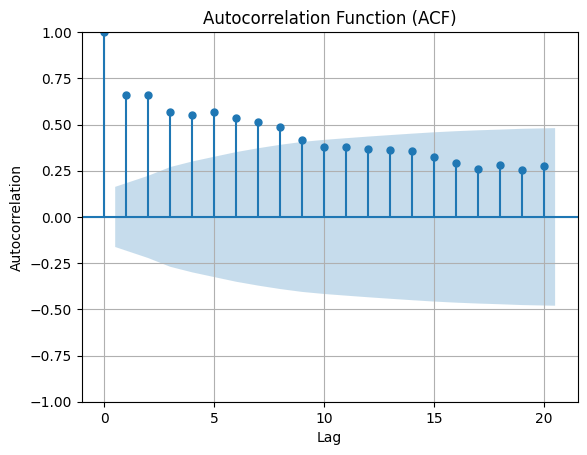

In [453]:
# Assuming you have already loaded your time series data into a DataFrame named 'df'

# Specify the number of lags you want to examine
max_lag = 20  # Adjust as needed

# Create the ACF plot
plot_acf(monthly_mean_pets, lags=max_lag)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

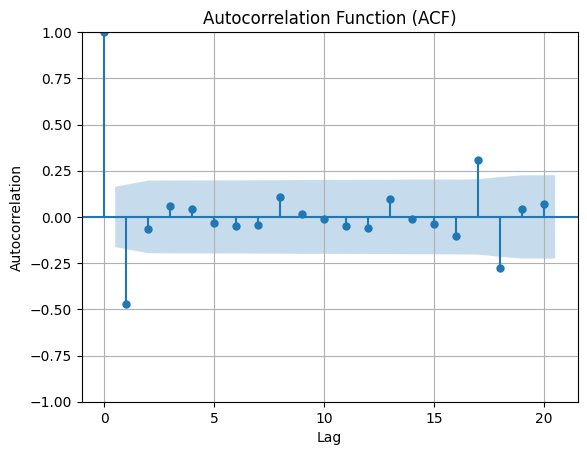

In [404]:
# Assuming you have already loaded your time series data into a DataFrame named 'df'

# Specify the number of lags you want to examine
max_lag = 20  # Adjust as needed

# Create the ACF plot
plot_acf(Stationnary_Data['value_diff'], lags=max_lag)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()


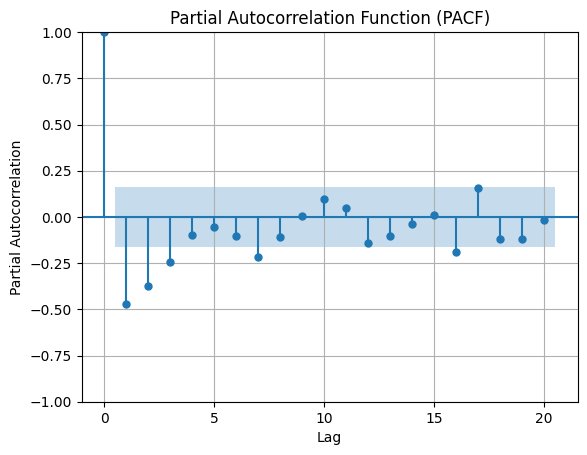

In [405]:
from statsmodels.graphics.tsaplots import plot_pacf

# Specify the number of lags you want to examine
max_lag = 20  # Adjust as needed

# Create the PACF plot
plot_pacf(Stationnary_Data['value_diff'], lags=max_lag)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()


## AR(1)

                            AutoReg Model Results                             
Dep. Variable:             value_diff   No. Observations:                  115
Model:                     AutoReg(1)   Log Likelihood                 406.863
Method:               Conditional MLE   S.D. of innovations              0.007
Date:                Fri, 06 Oct 2023   AIC                           -807.726
Time:                        20:41:31   BIC                           -799.517
Sample:                    03-31-2010   HQIC                          -804.394
                         - 08-31-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0003      0.001      0.407      0.684      -0.001       0.002
value_diff.L1    -0.4607      0.081     -5.706      0.000      -0.619      -0.302
                                    Root

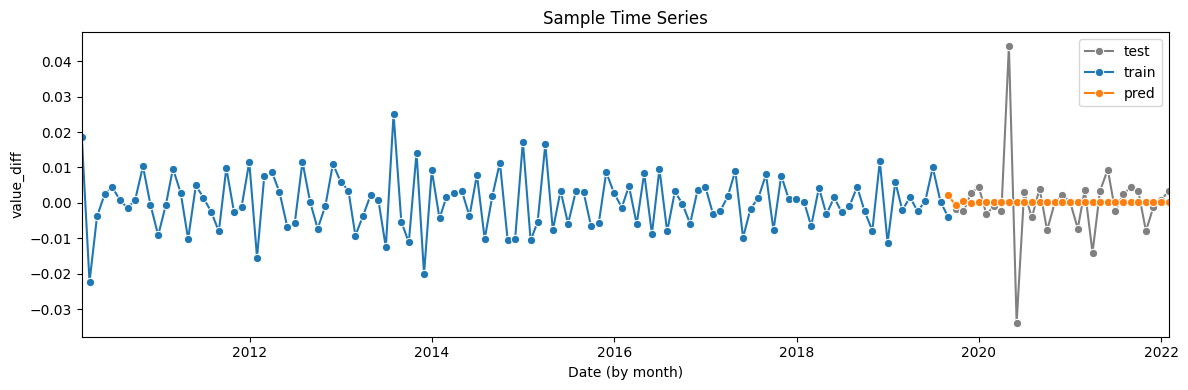

In [422]:
import seaborn as sns
train_len = int(0.8* Stationnary_Data['value_diff'].count())
num_samples = Stationnary_Data['value_diff'].count()
train = Stationnary_Data['value_diff'][:train_len]
ar_model = sm.tsa.AutoReg(train, lags=1).fit()

print(ar_model.summary())
pred = ar_model.predict(start=train_len, end=num_samples, dynamic=False)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
sns.lineplot(x=Stationnary_Data.index[train_len:num_samples], y=Stationnary_Data['value_diff'][train_len:num_samples], marker='o', label='test', color='grey')
sns.lineplot(x=Stationnary_Data.index[:train_len], y=train, marker='o', label='train')
sns.lineplot(x=Stationnary_Data.index[train_len-1:num_samples], y=pred, marker='o', label='pred')
ax.set_xlim([Stationnary_Data.index[0], Stationnary_Data.index[-1]])
ax.set_title('Sample Time Series')
plt.tight_layout()
plt.show()

## AR(2)

                            AutoReg Model Results                             
Dep. Variable:             value_diff   No. Observations:                  115
Model:                     AutoReg(2)   Log Likelihood                 417.591
Method:               Conditional MLE   S.D. of innovations              0.006
Date:                Fri, 06 Oct 2023   AIC                           -827.182
Time:                        20:48:13   BIC                           -816.272
Sample:                    04-30-2010   HQIC                          -822.755
                         - 08-31-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0005      0.001      0.961      0.337      -0.001       0.002
value_diff.L1    -0.6293      0.083     -7.613      0.000      -0.791      -0.467
value_diff.L2    -0.4275      0.081     

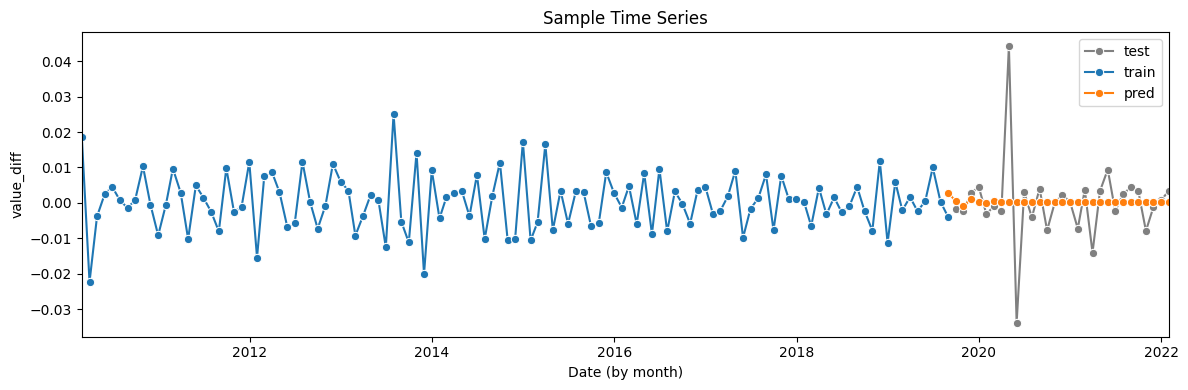

In [425]:
ar_model = sm.tsa.AutoReg(train, lags=2).fit()

print(ar_model.summary())
pred = ar_model.predict(start=train_len, end=num_samples, dynamic=False)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
sns.lineplot(x=Stationnary_Data.index[train_len:num_samples], y=Stationnary_Data['value_diff'][train_len:num_samples], marker='o', label='test', color='grey')
sns.lineplot(x=Stationnary_Data.index[:train_len], y=train, marker='o', label='train')
sns.lineplot(x=Stationnary_Data.index[train_len-1:num_samples], y=pred, marker='o', label='pred')
ax.set_xlim([Stationnary_Data.index[0], Stationnary_Data.index[-1]])
ax.set_title('Sample Time Series')
plt.tight_layout()
plt.show()

# ARIMA

                               SARIMAX Results                                
Dep. Variable:             value_diff   No. Observations:                  115
Model:                 ARIMA(2, 2, 1)   Log Likelihood                 371.819
Date:                Fri, 06 Oct 2023   AIC                           -735.638
Time:                        21:31:15   BIC                           -724.728
Sample:                    02-28-2010   HQIC                          -731.211
                         - 08-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0044      0.082    -12.303      0.000      -1.164      -0.844
ar.L2         -0.6226      0.072     -8.611      0.000      -0.764      -0.481
ma.L1         -0.9700      0.175     -5.545      0.0

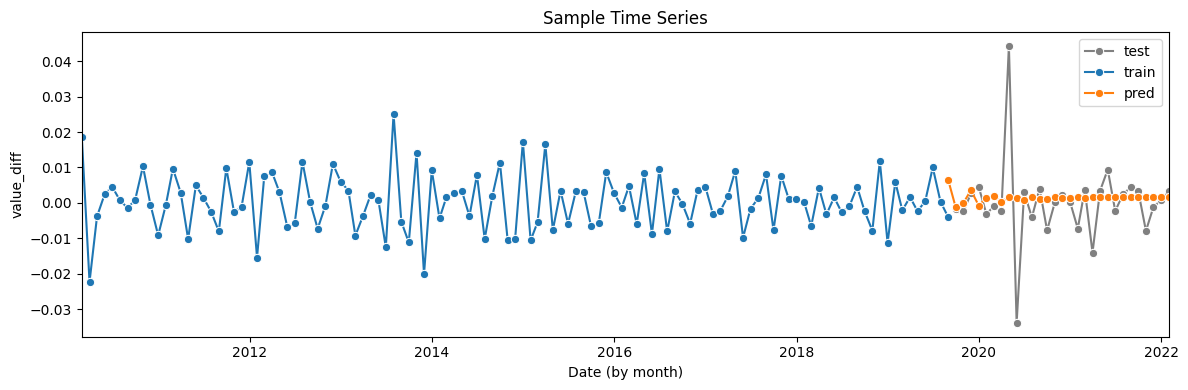

In [449]:
ma_model = sm.tsa.ARIMA(train, order=(2,2,1)).fit()
print(ma_model.summary())
pred = ma_model.predict(start=train_len, end=num_samples, dynamic=False)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
sns.lineplot(x=Stationnary_Data.index[train_len:num_samples], y=Stationnary_Data['value_diff'][train_len:num_samples], marker='o', label='test', color='grey')
sns.lineplot(x=Stationnary_Data.index[:train_len], y=train, marker='o', label='train')
sns.lineplot(x=Stationnary_Data.index[train_len-1:num_samples], y=pred, marker='o', label='pred')
ax.set_xlim([Stationnary_Data.index[0], Stationnary_Data.index[-1]])
ax.set_title('Sample Time Series')
plt.tight_layout()
plt.show()
